*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

In Module 1, we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google)

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [ ]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [ ]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2024-02-17 00:20:49--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     132  --.-KB/s    in 0s      

2024-02-17 00:20:49 (6.83 MB/s) - ‘requirements.txt’ saved [132/132]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

##1.0.3 Imports and such

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Part 1: Building a Latent Dirichlet Allocation (LDA) Topic Model with Gensim

Our goal in this module is to get hands-on experience in how to build and train a Latent Dirichlet Allocation topic model using the **Gensim** library.

## 1.1 Latent Dirichlet Allocation (LDA)
is a more sophisticated method of topic modelling than Latent Semantic Indexing (LSI) which we used in Module 2. Because of its complexity, a full discussion of the machinery of LDA is beyond the scope of Unit 4. We'll focus on a high level of understanding of Latent Dirichlet Allocation, meaning we'll emphasize "what it does" rather than "how it does it".

LDA takes as input the corpora of documents and the number of topics that you want to identify. LDA models topics as probability distributions over words, and it models documents as probability distributions over topics.

LDA is a generative probabilistic model. That means it can generate documents from probability distributions. Given an article length (number of words), an assumed probability distribution of topics, and an assumed distribution of words for each topic, LDA can generate an article, in the form of a bag of words. LDA works by starting with random distributions of words over topics and  topics over documents, then iteratively adjust these probability distributions until the generated documents are similar in structure to the input documents.





### 1.1.1 Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended Medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/) is an interactive data visualization tool -- created by the author of the above article -- that allows us to explore a simple and visual example of LDA.

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) disccusses an example implementing LDA using the same dataset that we are using in this guided project.  

Luis Serrano's video [**Latent Dirichlet Allocation**](https://youtu.be/T05t-SqKArY) does a great job of breaking down and explaining LDA in an understandable way.



### 1.1.2 Further discussion of LDA (Optional)

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

A PGM can be represented by a graph that expresses the conditional dependence structure between random variables. Here's a graphical representation of the LDA model:

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

The image shows the hierarchical dependency between probability distributions and their parameters. This is an application of Hierarchical Bayesian Modeling.

In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources:

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using four popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

[**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning.

## 1.2 Preparing our text data set for LDA topic modeling with `gensim`
For this guided project we'll work with the `20newsgroups` data set that is  familiar from Module 3, but we'll extract articles from a different set of categories.<br><br>
`gensim` is a Natural Language Processing Library, specialized for Topic Modeling applications. The two main inputs required for a `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.<br><br>
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br><br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`.<br>

In this section, we will first download and clean the raw text documents, then use `spacy` to tokenize and lemmatize them. Then we'll use `gensim` to create the `id2word` and `corpus` objects that we need for topic modeling with `gensim`<br>

In Part 2, we'll build and train the LDA topic model in `gensim`.

References:
- [Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

# Problem Statement



We'll extract articles belonging to the following four topics (as assigned in the 20newsgroups database)

    sci
        \_ electronics, space


    talk
        \_politics
                  \_ guns, middle east
              
What's the best way to categorize these emails - is it between science and talk?

Or it between electronics, space, guns, and the Middle East?

The Middle East is a pretty broad topic in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer these questions!

### Load Email Corpus


In [ ]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics
categories = ['sci.electronics', 'sci.space',
              'talk.politics.guns', 'talk.politics.mideast']
data = fetch_20newsgroups(subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

In [ ]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [ ]:
# create X and y from data, as we did in the Module 3 Lecture notebook
###BEGIN SOLUTION
X = data.data
y = data.target
target_names = data.target_names
###END SOLUTION

What are the possible targets (labels)

In [ ]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [ ]:
target_names

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [ ]:
data_dict = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data_dict)
print(df.shape)
df.head()

(3821, 3)


,content,target,target_names
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns
2,==========================\n ...,1,sci.space
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns


Re-use our `clean_data()` helper function from Module 3.

In [ ]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document.

    Parameters
    ----------
    text: string or object

    Returns
    -------
    text: string or object
    """

    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"

    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)

    # apply case normalization
    return text.lower().lstrip().rstrip()

Clean the text string data and save it in a new column

In [ ]:
df["clean_data"] = df["content"].apply(clean_data)
df.head()

,content,target,target_names,clean_data
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,some of the davidians are black next question
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,how about firearm related texas is unusual in ...
2,==========================\n ...,1,sci.space,ozone gif images april two gif images of the o...
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,from phil g fraering pgf srl cacs usl edu fina...
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article hydra gatech edu by gs prism gate...


### Create Tokens

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens.

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [ ]:
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_lg", disable=['tagger', 'parser'])

In [ ]:
%%time
# create our tokens in the form of lemmas

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# Ref: https://github.com/nalepae/pandarallel
#
# from tqdm import tqdm
# tqdm.pandas()
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)

# Parallel_map takes about 20 sec
df['lemmas'] = df['clean_data'].parallel_map(lambda x: [token.lemma_.strip() for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 1.86 s, sys: 536 ms, total: 2.4 s
Wall time: 1min 43s


### Take a look at our lemmas

In [ ]:
df['clean_data'][5]

'from gene wright gene theporch raider net i ll say imagine that there were a couple groups up there maybe landing a few weeks apart the year mark starts coming on for the first group isn t a billion pretty good incentive to take a shot at a potential winner yeah that s a shame that team a s life support gave out so close to the deadline thanks for the billion on the other hand if apollo cost billion for a few days or weeks in space in dollars then won t the reward have to be a lot more than only billion to get any takers tommy mac tom mcwilliams wk as the radius of vision increases tm ibm cl msu edu hm the circumference of mystery grows'

In [ ]:
# print out the lemmas from the first article
# note that some lemmas are only 1 character: you could modify the code above to not include lemmas that are only 1 or 2 characters
df['lemmas'][5]

['gene',
 'wright',
 'gene',
 'theporch',
 'raider',
 'net',
 'll',
 'imagine',
 'couple',
 'groups',
 'maybe',
 'landing',
 'weeks',
 'apart',
 'year',
 'mark',
 'starts',
 'coming',
 'group',
 'isn',
 't',
 'billion',
 'pretty',
 'good',
 'incentive',
 'shot',
 'potential',
 'winner',
 'yeah',
 's',
 'shame',
 'team',
 's',
 'life',
 'support',
 'gave',
 'close',
 'deadline',
 'thanks',
 'billion',
 'hand',
 'apollo',
 'cost',
 'billion',
 'days',
 'weeks',
 'space',
 'dollars',
 'won',
 't',
 'reward',
 'lot',
 'billion',
 'takers',
 'tommy',
 'mac',
 'tom',
 'mcwilliams',
 'wk',
 'radius',
 'vision',
 'increases',
 'tm',
 'ibm',
 'cl',
 'msu',
 'edu',
 'hm',
 'circumference',
 'mystery',
 'grows']

### Filter out low quality lemmas
1 or 2 characters

In [ ]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [ ]:
# apply filter_lemmas
df["filtered_lemmas"] = df["lemmas"].parallel_map(filter_lemmas)

In [ ]:
df["filtered_lemmas"][5]

['gene',
 'wright',
 'gene',
 'theporch',
 'raider',
 'net',
 'imagine',
 'couple',
 'groups',
 'maybe',
 'landing',
 'weeks',
 'apart',
 'year',
 'mark',
 'starts',
 'coming',
 'group',
 'isn',
 'billion',
 'pretty',
 'good',
 'incentive',
 'shot',
 'potential',
 'winner',
 'yeah',
 'shame',
 'team',
 'life',
 'support',
 'gave',
 'close',
 'deadline',
 'thanks',
 'billion',
 'hand',
 'apollo',
 'cost',
 'billion',
 'days',
 'weeks',
 'space',
 'dollars',
 'won',
 'reward',
 'lot',
 'billion',
 'takers',
 'tommy',
 'mac',
 'tom',
 'mcwilliams',
 'radius',
 'vision',
 'increases',
 'ibm',
 'msu',
 'edu',
 'circumference',
 'mystery',
 'grows']

### The two main inputs to the `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

### Create the `id2word` dictionary

In [ ]:
# 1. Create Dictionary

# 2. Term Document Frequency is (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)

### BEGIN SOLUTION
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['filtered_lemmas'])

In [ ]:
# How many words do we have in our vocabulary?
len(id2word.keys())

33988

In [ ]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above = 0.5)

In [ ]:
# Now how many words do we have in our vocabulary dictionary?
len(id2word.keys())

12995

Use the `id2word.doc2bow()` method to process a first document into a list of word counts

In [ ]:
id2word.doc2bow(df['filtered_lemmas'][5])

[(29, 1),
 (35, 1),
 (103, 1),
 (175, 1),
 (179, 1),
 (197, 1),
 (199, 1),
 (206, 1),
 (209, 1),
 (210, 1),
 (213, 1),
 (214, 1),
 (216, 1),
 (217, 1),
 (226, 1),
 (235, 1),
 (236, 1),
 (241, 1),
 (259, 1),
 (260, 1),
 (261, 4),
 (262, 1),
 (263, 1),
 (264, 1),
 (265, 1),
 (266, 1),
 (267, 1),
 (268, 2),
 (269, 1),
 (270, 1),
 (271, 1),
 (272, 1),
 (273, 1),
 (274, 1),
 (275, 1),
 (276, 1),
 (277, 1),
 (278, 1),
 (279, 1),
 (280, 1),
 (281, 1),
 (282, 1),
 (283, 1),
 (284, 1),
 (285, 1),
 (286, 1),
 (287, 1),
 (288, 2),
 (289, 1),
 (290, 1),
 (291, 1),
 (292, 1),
 (293, 1)]

### Create the `corpus`
by processing all the documents using a list comprehension

In [ ]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['filtered_lemmas']]

# Check the data type and length of corpus
print(type(corpus))
print(len(corpus))

<class 'list'>
3821


In [ ]:

### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

### END SOLUTION

[('group', 1),
 ('isn', 1),
 ('days', 1),
 ('space', 1),
 ('team', 1),
 ('circumference', 1),
 ('edu', 1),
 ('grows', 1),
 ('ibm', 1),
 ('increases', 1),
 ('mac', 1),
 ('mcwilliams', 1),
 ('msu', 1),
 ('mystery', 1),
 ('radius', 1),
 ('tom', 1),
 ('tommy', 1),
 ('vision', 1),
 ('apart', 1),
 ('apollo', 1),
 ('billion', 4),
 ('close', 1),
 ('coming', 1),
 ('cost', 1),
 ('couple', 1),
 ('dollars', 1),
 ('gave', 1),
 ('gene', 2),
 ('good', 1),
 ('groups', 1),
 ('hand', 1),
 ('imagine', 1),
 ('incentive', 1),
 ('landing', 1),
 ('life', 1),
 ('lot', 1),
 ('mark', 1),
 ('maybe', 1),
 ('net', 1),
 ('potential', 1),
 ('pretty', 1),
 ('reward', 1),
 ('shame', 1),
 ('shot', 1),
 ('starts', 1),
 ('support', 1),
 ('thanks', 1),
 ('weeks', 2),
 ('winner', 1),
 ('won', 1),
 ('wright', 1),
 ('yeah', 1),
 ('year', 1)]

# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20,
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

#### The multi-processor version of gensim's LDA model is `gensim.models.ldamulticore.LdaMulticore()`, <br> which runs faster than the single-core version `gensim.models.ldamodel.LdaModel()`


In [ ]:
%%time
from gensim.models.ldamulticore import LdaMulticore
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_topics = 2
lda_multicore_2_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,              # Runtime related parameter
                                      per_word_topics=True,
                                      workers=10,             # Set based on your machine capability
                                      random_state=42)

CPU times: user 10.7 s, sys: 790 ms, total: 11.5 s
Wall time: 42.8 s


In [ ]:
num_topics = 6
lda_multicore_6_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,
                                      per_word_topics=True,
                                      workers=10,
                                      random_state=42)

# Part 3: Interpret LDA results & Select the appropriate number of topics
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>


### 3.1 Visualizing the topics in our models

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.120099  0.0       1        1  59.340865
0     -0.120099  0.0       2        1  40.659135, topic_info=       Term         Freq        Total Category  logprob  loglift
175   space  1317.000000  1317.000000  Default  30.0000  30.0000
580  israel   801.000000   801.000000  Default  29.0000  29.0000
145    nasa   439.000000   439.000000  Default  28.0000  28.0000
668    data   424.000000   424.000000  Default  27.0000  27.0000
50   people  2040.000000  2040.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
18      don   425.940528  1433.139335   Topic2  -5.8010  -0.3134
330     etc   249.177353   358.930752   Topic2  -6.3371   0.5350
186   years   283.662651   637.523458   Topic2  -6.2075   0.0901
73    think   297.576463   968.729861   Topic2  -6.1596  -0.2804
640    want   241.965990   629.016277   Topic2  -6.3665  -0.0554

[162 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8406      1  0.998604     ankara
8406      2  0.008392     ankara
6919      1  0.995076  apartment
6919      2  0.005590  apartment
1321      1  0.997835       arab
...     ...       ...        ...
1911      2  0.028906      women
553       1  0.384112       work
553       2  0.615832       work
186       1  0.555274      years
186       2  0.445474      years

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.114464  0.041791       1        1  26.389147
4      0.205290 -0.066245       2        1  25.809664
3     -0.025849 -0.056652       3        1  18.046964
1     -0.052786  0.211155       4        1  11.551505
5     -0.144922 -0.122880       5        1  10.809168
0     -0.096197 -0.007169       6        1   7.393552, topic_info=           Term         Freq        Total Category  logprob  loglift
175       space  1387.000000  1387.000000  Default  30.0000  30.0000
793    armenian   984.000000   984.000000  Default  29.0000  29.0000
580      israel   814.000000   814.000000  Default  28.0000  28.0000
794   armenians   810.000000   810.000000  Default  27.0000  27.0000
1883    turkish   599.000000   599.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
476       state    65.444304   559.514408   Topic6  -5.9695   0.4587
186       years    65.183240   630.951176   Topic6  -5.9735   0.3345
1883    turkish    64.229143   599.741461   Topic6  -5.9882   0.3705
18          don    66.963583  1444.998996   Topic6  -5.9465  -0.4672
256      second    61.510784   371.990418   Topic6  -6.0315   0.8049

[453 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1258       1  0.971344  accidents
1258       2  0.023691  accidents
516        1  0.552337   actually
516        2  0.212665   actually
516        3  0.159498   actually
...      ...       ...        ...
10995      6  0.945818       zinc
2398       3  0.983484    zionism
2399       3  0.962515    zionist
2399       6  0.030079    zionist
9702       5  0.950465       zuma

[1092 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 6, 1])

###3.2 What is topic coherence?


_Topic Coherence measures score a single topic by
measuring the degree of semantic similarity between
high scoring words in the topic._ <br>
-- From "Exploring Topic Coherence over many models and many topics", by Keith Stevens, Philip Kegelmeyer, David Andrzejewski, and David Buttler, Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural
Language Learning, pages 952–961, Jeju Island, Korea, 12–14 July 2012.
c 2012 Association for Computational Linguistics

_A set of statements or facts is said to be coherent, if they
support each other. Thus, a coherent fact set can be interpreted
in a context that covers all or most of the facts. An
example of a coherent fact set is 'the game is a team sport',
'the game is played with a ball', and 'the game demands great
physical e
fforts'_ -- from "Exploring the Space of Topic Coherence Measures", by Michael Roder, Andreas Both and Alexander Hinneburg https://dl.acm.org/doi/10.1145/2684822.2685324

We expect that documents in a topic category should be coherent, i.e., they should relate to each other. The same is true for words within a topic.


### Let's tune the "number of topics" hyperparameter
and choose the model with the best Topic Coherence score.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['filtered_lemmas'], start=2, limit=10, step=1)

CPU times: user 1min 11s, sys: 4.47 s, total: 1min 16s
Wall time: 3min 21s


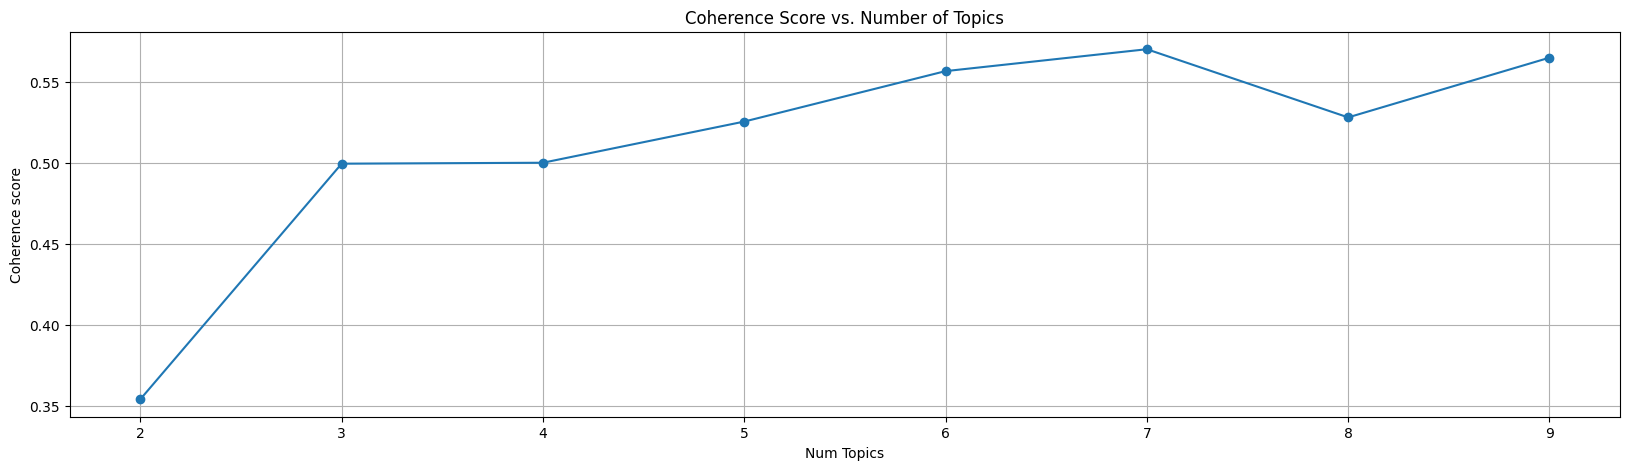

In [ ]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(x, coherence_values, "-o")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show();

### Select the "best" model as the one with the highest Topic Coherence Score

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus.

In [ ]:
lda_trained_model = model_list[4]

In [ ]:
lda_trained_model

### For each topic discovered by `gensim`, list the top ten words and their probabilities,

In [ ]:
pprint(lda_trained_model.print_topics())

###Visualize the topics in the best model

In [ ]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.044076 -0.085385       1        1  23.448602
0     -0.177141 -0.037900       2        1  20.637908
2     -0.146155  0.108015       3        1  19.064479
4      0.121213 -0.022748       4        1  18.375084
3      0.113676 -0.161152       5        1  12.536071
1      0.132483  0.199169       6        1   5.937857, topic_info=          Term         Freq        Total Category  logprob  loglift
175      space  1336.000000  1336.000000  Default  30.0000  30.0000
793   armenian  1054.000000  1054.000000  Default  29.0000  29.0000
199        edu   464.000000   464.000000  Default  28.0000  28.0000
592        gun   813.000000   813.000000  Default  27.0000  27.0000
580     israel   742.000000   742.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2964      mail    58.470749   190.850514   Topic6  -5.8629   1.6409
668       data    63.138674   423.669202   Topic6  -5.7861   0.9202
1386    turkey    59.971224   360.986847   Topic6  -5.8375   1.0288
1227      york    55.554948   174.884789   Topic6  -5.9140   1.6771
146       news    53.523819   295.818998   Topic6  -5.9513   1.1142

[463 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6192      1  0.952405  accidental
6192      2  0.021646  accidental
6192      6  0.021646  accidental
1258      1  0.969736   accidents
516       1  0.525378    actually
...     ...       ...         ...
1227      4  0.097207        york
1227      6  0.320211        york
3497      2  0.020772  yugoslavia
3497      3  0.955510  yugoslavia
9702      3  0.946661        zuma

[1211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 5, 4, 2])

## Create a Topic Id --> Topic Name dictionary


*****This is the "human intervention" step*****:<br>
Edit `vis_topic_name_dict` with YOUR OWN names that YOU assign to the topics that `gensim` discovered.

When populating your Topic Id --> Topic Name dictionary, use the index ordering as shown in the `pyLDAvis` tool.

In [ ]:
# keys - use topic ids from pyLDAvis visualization
# values - topic names that you create
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture
vis_topic_name_dict = {1: 'Guns',
                       2: 'Middle East',
                       3: 'History',
                       4: 'Space',
                       5: 'Technology',
                       6: 'ETC'}
###END SOLUTION

## Create a Topic Id lookup dictionary
We'll use a function to map the `pyLDAvis` index ordering to the ordering used in gensim's trained LDA model.

In [ ]:
model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
model_vis_tool_topic_id_lookup

{5: 1, 0: 2, 2: 3, 4: 4, 3: 5, 1: 6}

In [ ]:
topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
topic_id_lookup

{1: 5, 2: 0, 3: 2, 4: 4, 5: 3, 6: 1}

In [ ]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model
    and the viz tool are different. So we need to create a look up dictionary that maps
    the correct association between topic ids from both sources.
    """
    # value is order of topic ids according to pyLDAvis tool
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that
    # key is order of topic ids accoridng to pyLDAvis tool
    # value is order of topic ids according to the trained lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}

    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [ ]:
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has indexed the topics
# now we can use this dictionary with lda model to label our docs
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [ ]:
topic_name_dict

{5: 'Guns',
 0: 'Middle East',
 2: 'History',
 4: 'Space',
 3: 'Technology',
 1: 'ETC'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name.

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output.

In [ ]:
def get_topic_ids_for_docs(lda_model, corpus):

    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document.

    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model

    corpus: nested lists of tuples,
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]

    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus
    """

    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:

        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)

        # iterate through the topic id/prob pairs
        for topic_id_prob in topic_id_prob_tuples:

            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)

    return doc_topic_ids

In [ ]:
# get the topic id for each doc in the corpus
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,some of the davidians are black next question,"[davidians, black, question]","[davidians, black, question]",5,Guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,how about firearm related texas is unusual in ...,"[firearm, related, texas, unusual, regard, nic...","[firearm, related, texas, unusual, regard, nic...",5,Guns
2,==========================\n ...,1,sci.space,ozone gif images april two gif images of the o...,"[ozone, gif, images, april, gif, images, ozone...","[ozone, gif, images, april, gif, images, ozone...",1,ETC
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,from phil g fraering pgf srl cacs usl edu fina...,"[phil, g, fraering, pgf, srl, cacs, usl, edu, ...","[phil, fraering, pgf, srl, cacs, usl, edu, fin...",4,Space
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article hydra gatech edu by gs prism gate...,"[article, hydra, gatech, edu, gs, prism, gatec...","[article, hydra, gatech, edu, prism, gatech, e...",1,ETC


Using a boolean filter, or mask, you can slice out all articles of a certain topic, i.e. topic_id 3

In [ ]:
mask = df.topic_id == 3
df[mask]

In [ ]:
df[mask].target_names.value_counts(normalize=True)

target_names
sci.electronics          0.874007
sci.space                0.083995
talk.politics.guns       0.027242
talk.politics.mideast    0.014756
Name: proportion, dtype: float64

-----

## Knowledge is Power! What Can We Do with the Knowledge We Just Gained?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that you won't always have a point of reference to "check your answers". So let's explore two possible situations in which you might find yourself using Latent Dirichlet Allocation (LDA) Topic Modeling.

### 1. You have access to existing document topic labels

In this case, why would you bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, in this guided project, our email dataset has topic names; however those topic labels are hierarchical, which may not suit your needs. So one option is generate new labels that do suit your needs (as we did here).

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!

## Topic Modeling References


- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures